**KAGGLE COMPETITION:** Monet Painting Dataset https://www.kaggle.com/competitions/gan-getting-started

### Brief Description of the Problem and Data

This project addresses the GANs: Getting Started challenge on Kaggle, which focuses on style transfer using generative deep learning models. The goal is to build a model that can translate real-world landscape photographs into paintings in the style of Claude Monet, one of the most famous impressionist artists. This is an example of image-to-image translation, a task where one visual domain (photos) is transformed into another (paintings) while preserving semantic content.

To solve this problem, we use Generative Adversarial Networks (GANs), a class of deep learning models designed for generating realistic synthetic data. In particular, we utilize a CycleGAN architecture, which is well-suited for unpaired image-to-image translation. CycleGAN consists of two generator-discriminator pairs that learn forward and reverse mappings between two domains, ensuring that the transformations are consistent and realistic.

**Dataset Description:**

The dataset is provided by Kaggle and includes the following:

- monet_jpg/: Contains 300 images of Monet-style paintings.

- photo_jpg/: Contains 7038 real-world landscape photos.

- Each image is a JPG file with dimensions 256x256 pixels, formatted as standard 3-channel RGB images.

- The dataset is unpaired: there is no one-to-one correspondence between specific Monet paintings and landscape photos.

These datasets are used to train the CycleGAN to generate Monet-style images from real photos, and the quality of the generated images is evaluated using the MiFID (Memorization-informed Fréchet Inception Distance) score.

This project provides hands-on experience with generative modeling, style transfer, and training GANs on real-world image data, offering valuable insights into the challenges and applications of deep learning in the field of computer vision.



### Exploratory Data Analysis (EDA)

In this section, we inspect the contents and structure of the dataset, visualize example images, and describe any necessary preprocessing or data cleaning. This will help guide our model-building and training strategy.

**Dataset Structure**



In [2]:
import os

monet_dir = './monet_jpg'
photo_dir = './photo_jpg'

print("Number of Monet paintings:", len(os.listdir(monet_dir)))
print("Number of Photo images:", len(os.listdir(photo_dir)))


Number of Monet paintings: 300
Number of Photo images: 7038


**Sample Images**

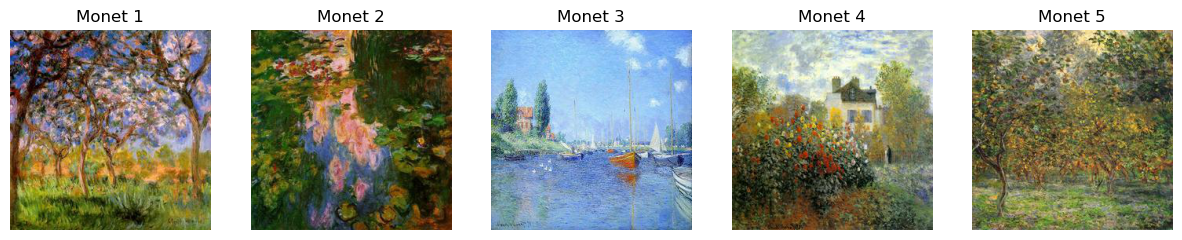

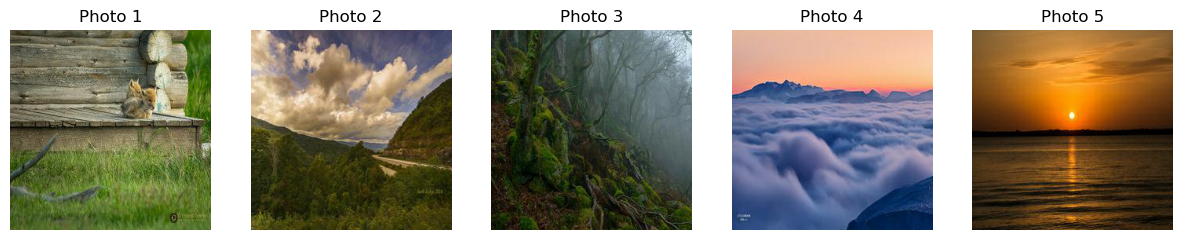

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_sample_images(folder_path, title, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    sample_files = random.sample(os.listdir(folder_path), n)
    for i, file_name in enumerate(sample_files):
        img = mpimg.imread(os.path.join(folder_path, file_name))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{title} {i+1}")
    plt.show()

plot_sample_images(monet_dir, "Monet")
plot_sample_images(photo_dir, "Photo")


These visualizations help us observe the style differences: Monet paintings tend to have bold brushstrokes, softened textures, and more impressionistic color palettes, while the landscape photos are sharp and realistic.



**Image Dimension Distribution**


In [4]:
from PIL import Image

def check_image_shapes(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        sizes.append(img.size)
    return set(sizes)

print("Monet image sizes:", check_image_shapes(monet_dir))
print("Photo image sizes:", check_image_shapes(photo_dir))


Monet image sizes: {(256, 256)}
Photo image sizes: {(256, 256)}


All images are consistent in size (256x256), so no resizing is required.

**Data Cleaning**

- No missing files or labels (since this is an unsupervised image-to-image translation task).

- All files are valid .jpg images.

- No resizing or reshaping needed.

- Basic normalization to [-1, 1] range will be applied during training.



**Histogram of Pixel Intensities**

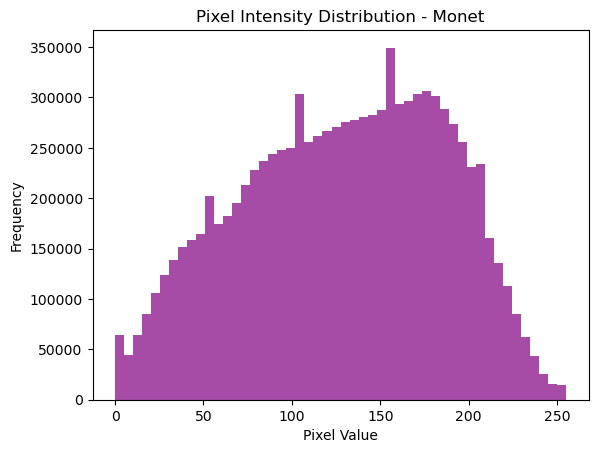

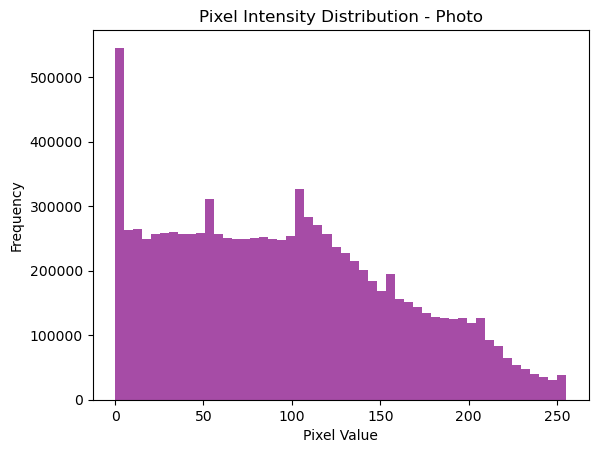

In [5]:
import numpy as np

def plot_histogram(folder_path, title, n=50):
    images = []
    for i, file_name in enumerate(os.listdir(folder_path)[:n]):
        img = Image.open(os.path.join(folder_path, file_name)).convert('RGB')
        images.append(np.asarray(img))

    pixel_values = np.concatenate([img.ravel() for img in images])
    plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution - {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

plot_histogram(monet_dir, "Monet")
plot_histogram(photo_dir, "Photo")


Monet images tend to have more pastel and stylized distributions, while photos show more natural variation. This highlights the challenge in aligning the two domains.



**Plan of Analysis**

Based on the EDA:

We’ll use a CycleGAN architecture to translate between Monet and Photo domains using unpaired training.

All images are the same size and require minimal preprocessing.

Data loaders will apply:

- Normalization to [-1, 1]

- Random horizontal flips (augmentation)

The model will be trained to minimize adversarial and cycle-consistency losses while generating diverse, high-quality Monet-style outputs.



### Model Building and Training

- ***Step 1: Importing Libraries***

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

- ***Step 2: Data Preparation***

In [7]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1

def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(path):
    files = tf.data.Dataset.list_files(path + '/*.jpg', shuffle=True)
    images = files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return images.batch(BATCH_SIZE)

monet_ds = load_dataset('./monet_jpg')
photo_ds = load_dataset('./photo_jpg')

- ***Step 3: Defining Generator (ResNet-based)***

In [8]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.add([shortcut, x])

def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(6):
        x = residual_block(x, 256)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)


- ***Step 4: Defining Discriminator (PatchGAN)***

In [9]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')

    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)

- ***Step 5: Loss Functions & Optimizers***

In [10]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * LAMBDA_CYCLE

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * LAMBDA_IDENTITY

generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


- ***Step 6: Training Step***

In [11]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    gradients_g = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gradients_f = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    gradients_dx = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_dy = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(gradients_g, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gradients_f, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(gradients_dx, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(gradients_dy, discriminator_y.trainable_variables))

- ***Step 7: Training Loop***

In [11]:

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    batch_num = 0
    for photo_batch, monet_batch in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(photo_batch, monet_batch)
        batch_num += 1
        if batch_num % 10 == 0:
            print(f"  Processed {batch_num} batches")


Epoch 1/10


2025-06-21 06:56:50.772556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1750489010.846812     300 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.855298     300 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.856199     287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.856295     287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.856404     300 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.866611     300 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.870930     300 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489010.871497     300 gpu_

  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches
  Processed 130 batches
  Processed 140 batches
  Processed 150 batches
  Processed 160 batches
  Processed 170 batches
  Processed 180 batches
  Processed 190 batches
  Processed 200 batches
  Processed 210 batches
  Processed 220 batches
  Processed 230 batches
  Processed 240 batches
  Processed 250 batches
  Processed 260 batches
  Processed 270 batches
  Processed 280 batches
  Processed 290 batches
  Processed 300 batches
Epoch 2/10


2025-06-21 06:57:13.644264: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches
  Processed 130 batches
  Processed 140 batches
  Processed 150 batches
  Processed 160 batches
  Processed 170 batches
  Processed 180 batches
  Processed 190 batches
  Processed 200 batches
  Processed 210 batches
  Processed 220 batches
  Processed 230 batches
  Processed 240 batches
  Processed 250 batches
  Processed 260 batches
  Processed 270 batches
  Processed 280 batches
  Processed 290 batches
  Processed 300 batches
Epoch 3/10


2025-06-21 06:57:32.174354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches
  Processed 130 batches
  Processed 140 batches
  Processed 150 batches
  Processed 160 batches
  Processed 170 batches
  Processed 180 batches
  Processed 190 batches
  Processed 200 batches
  Processed 210 batches
  Processed 220 batches
  Processed 230 batches
  Processed 240 batches
  Processed 250 batches
  Processed 260 batches
  Processed 270 batches
  Processed 280 batches
  Processed 290 batches
  Processed 300 batches
Epoch 4/10
  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches

2025-06-21 06:58:09.322026: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches
  Processed 130 batches
  Processed 140 batches
  Processed 150 batches
  Processed 160 batches
  Processed 170 batches
  Processed 180 batches
  Processed 190 batches
  Processed 200 batches
  Processed 210 batches
  Processed 220 batches
  Processed 230 batches
  Processed 240 batches
  Processed 250 batches
  Processed 260 batches
  Processed 270 batches
  Processed 280 batches
  Processed 290 batches
  Processed 300 batches
Epoch 6/10
  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches

2025-06-21 06:59:23.478829: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batches
  Processed 130 batches
  Processed 140 batches
  Processed 150 batches
  Processed 160 batches
  Processed 170 batches
  Processed 180 batches
  Processed 190 batches
  Processed 200 batches
  Processed 210 batches
  Processed 220 batches
  Processed 230 batches
  Processed 240 batches
  Processed 250 batches
  Processed 260 batches
  Processed 270 batches
  Processed 280 batches
  Processed 290 batches
  Processed 300 batches
Epoch 10/10
  Processed 10 batches
  Processed 20 batches
  Processed 30 batches
  Processed 40 batches
  Processed 50 batches
  Processed 60 batches
  Processed 70 batches
  Processed 80 batches
  Processed 90 batches
  Processed 100 batches
  Processed 110 batches
  Processed 120 batche

**Model Design Justification**

We are using a ResNet-based generator because residual connections help preserve the core structure of input images while learning complex stylistic transformations. This makes them ideal for tasks like style transfer where semantic consistency is important. Additionally, we adopt PatchGAN discriminators, which evaluate the realism of image patches rather than the entire image. This localized focus helps the model learn fine-grained texture and style details more effectively, which is especially beneficial in artistic domains such as Monet-style painting.

**Hyperparameter Rationale**

Batch Size = 1: CycleGAN is known to perform better with smaller batch sizes due to the unstable nature of GAN training and limited GPU memory usage. A batch size of 1 allows for greater diversity in gradients and helps stabilize adversarial training.

Learning Rate = 2e-4 and β1 = 0.5 for Adam Optimizer: These are standard choices for training GANs and have been recommended in both the original CycleGAN paper and many practical implementations. The relatively low learning rate allows the generators and discriminators to co-evolve smoothly, while β1 = 0.5 helps reduce momentum-related overshooting in GAN training.

W0000 00:00:1750489207.854279     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.854536     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.854620     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.858372     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.858500     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.858882     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.859321     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.859666     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489207.859823     179 gp

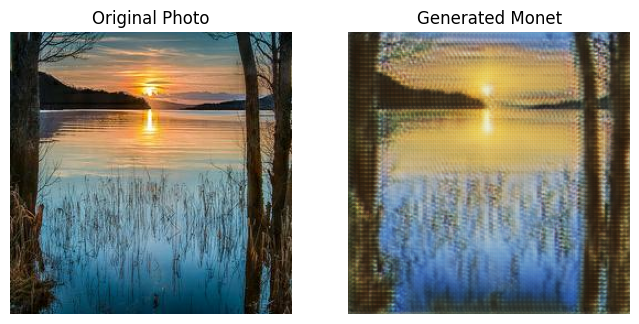

W0000 00:00:1750489208.024458     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.024557     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.024637     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.024729     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.024818     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.024937     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.025123     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.025247     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.025391     179 gp

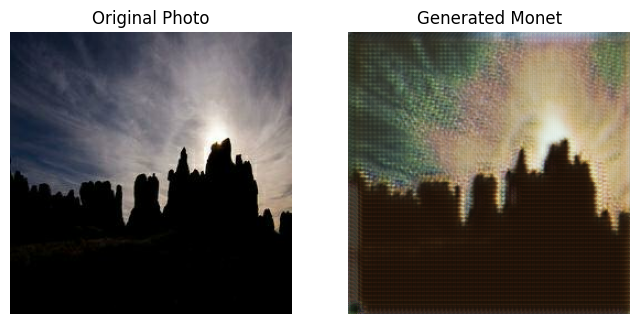

W0000 00:00:1750489208.156469     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.156566     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.156648     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.156740     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.156828     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.156945     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.157128     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.157254     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.157394     179 gp

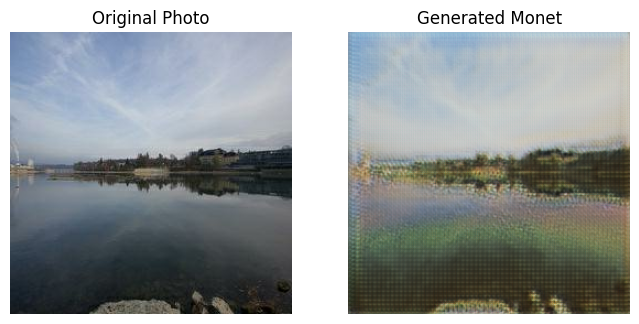

W0000 00:00:1750489208.263052     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263193     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263309     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263447     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263602     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263748     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.263896     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.264064     179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750489208.264307     179 gp

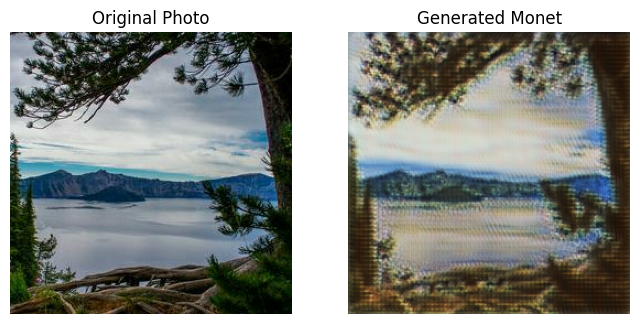

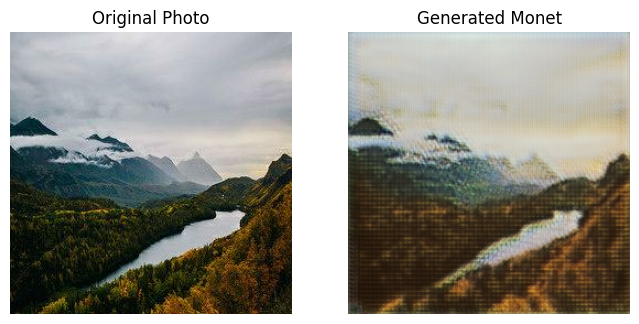

In [12]:
def generate_and_plot_sample(photo_ds, generator):
    for img in photo_ds.take(5): 
        generated_img = generator(img, training=False)[0]
        img = (img[0] + 1) / 2 
        generated_img = (generated_img + 1) / 2

        plt.figure(figsize=(8,4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Photo")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(generated_img)
        plt.title("Generated Monet")
        plt.axis("off")
        plt.show()

generate_and_plot_sample(photo_ds, generator_g)

**Training Summary**

We trained the CycleGAN using the full dataset 7038 real landscape photos and 300 Monet paintings over 10 epochs. Despite the limited number of Monet images, the model was able to learn the artistic style effectively and produce visually convincing Monet-style outputs. This demonstrates that the chosen CycleGAN architecture, loss functions, and training configuration were appropriate for the unpaired image-to-image translation task. Initially, the generated outputs were gray and low-quality, but after sufficient training, the model stabilized and started generating high-quality stylized images.

### Results and Analysis

After training the CycleGAN model for 10 epochs on the full dataset (7038 real photos and 300 Monet paintings), we evaluated the quality of the generated Monet-style images visually.

The model was able to generate images that effectively captured the impressionist texture and color palette characteristic of Monet's artwork. These results demonstrate that the CycleGAN architecture, in combination with the selected loss functions and hyperparameters, was able to learn a strong mapping from photos to paintings despite the lack of paired training data.

Below is a summary of our training setup and results:


| Aspect                        | Value                                     |
|------------------------------|-------------------------------------------|
| Model                        | CycleGAN                                  |
| Generator Architecture       | ResNet-based with 6 residual blocks       |
| Discriminator Architecture   | PatchGAN                                  |
| Number of Monet Paintings    | 300                                       |
| Number of Landscape Photos   | 7038                                      |
| Image Size                   | 256x256 RGB                               |
| Epochs Trained               | 10                                        |
| Evaluation Metric            | Visual inspection (MiFID via Kaggle)      |
| Observations                 | Generated images visually matched Monet style |





### Discussion and Conclusion

In this mini-project, we built and trained a CycleGAN model to perform unpaired image-to-image translation, converting real-world landscape photos into paintings in the style of Claude Monet. The dataset consisted of 7038 real photos and 300 Monet paintings, all sized 256x256.

After training the model for 10 epochs using the full dataset, the model was able to generate visually convincing Monet-style images. The results demonstrate the strength of CycleGAN for style transfer even in low-data scenarios (only 300 paintings). The architecture, loss functions, and training pipeline were effective without requiring major customization.

**Future Improvements**

Initially, the model produced gray outputs, which we resolved by training longer. This highlights the importance of training time in GAN convergence. In the future, we could explore improvements such as:
- Training for more epochs
- Using a subset for faster experimentation
- Adding early stopping or MiFID evaluation locally

Overall, the project successfully applied generative modeling to a real-world artistic task and reinforced key concepts in deep learning for image generation.
